In [8]:
import pandas as pd  ## צמצום טבלאות אוכלוסיה ויערות מ1990-2019
import matplotlib as mpl
import numpy as np
from matplotlib import pyplot as plt

df = pd.read_csv('population-since-1800.csv') 
df = df[(df['Year'] >= 1990) & (df['Year'] <= 2019)]
df.to_csv('population-since-1800.csv')
df2 = pd.read_csv('% of total forest per country.csv') 
df2 = df2[(df2['Year'] >= 1990) & (df2['Year'] <= 2019)]
df2.to_csv('% of total forest per country.csv')

  #מיזוג 2 הטבלאות באמצעות פקודה מרג בהסתמך על ארץ ושנה דומות ומיזוג עם המאגר הגדול יותר כדי לא לאבד יותר מידי נתונים (וכך השורות החסרות הצטרפו)
output1 = pd.merge(df, df2, how='left', on=['Entity', 'Year'])
output1.to_csv('output1.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'population-since-1800.csv'

In [34]:
merged = pd.read_csv('NewData-Forest+Population.csv')
for i in merged.columns[merged.isnull().any(axis=0)]:   
    merged[i].fillna(merged.groupby('Entity')[i].transform("median"),inplace=True)
#בדיקת ערכי הנאל בטבלה המאוחדת שלנו והשלמת החציון באמצעות הקבוצות הספציפיות בלבד(לדוגמא אפגניסטן וחישוב הממוצע שלה בלבד)       
merged.to_csv('NewDataBase-Forest+Population.csv')            

In [36]:
Mortality = pd.read_csv('Mortality.csv')
Mortality = Mortality[(Mortality['Year'] >= 1990) & (Mortality['Year'] <= 2019)]
output1 = pd.merge(merged, Mortality, how='inner', on=['Entity', 'Year'])
output1.to_csv('Forest+Population+Mortality.csv')
#שילוב קובץ נוסף ואיחוד שלו הפעם על ידי inner כי היו יותר מידי נתונים להשלים

In [70]:
undernourishment = pd.read_csv('prevalence-of-undernourishment.csv')
undernourishment['undernourishment_prevalence'].replace('<2.5',2.5,inplace=True)
undernourishment['undernourishment_prevalence'] = undernourishment['undernourishment_prevalence'].astype(float)
undernourishment.to_csv('prevalence-of-undernourishment.csv') 
#לקיחת הקובץ של הרעב החלפת ערכים שנצטרך לחשב בעתיד בערכים מספריים כי קיבלנו קובץ עם עמוד אוגבגקט והחלפנו לפלוט.

In [91]:
combined= pd.merge(output1, undernourishment, how='left', on=['Entity', 'Year'])

combined['undernourishment_prevalence'].fillna(combined.groupby('Entity')['undernourishment_prevalence'].transform("median"),inplace=True)
combined['undernourishment_prevalence'] = combined['undernourishment_prevalence'].fillna(0)
    
combined.to_csv('Forest+Mortality+Population+undernourishment.csv')     
# איחדנו את נתוני הרעב ביחד עם הקובץ הקיים שלנו תוך כדי השלמנו את הערכים הריקים בחציון או ב 0 אם לא היה ידע מקדים

In [93]:
lastCombined = pd.read_csv('Forest+Mortality+Population+undernourishment .csv')
kmpercountry=  pd.read_csv('km forest per coutnry.csv')
new = pd.merge(lastCombined, kmpercountry, how='left', on=['Entity', 'Year'])
new['Forest area'].fillna(new.groupby('Entity')['Forest area'].transform("median"),inplace=True)
new.to_csv('Forest+Mortality+Population+undernourishment+forestPerCountry.csv')
#הוספנו קילומטר יער פר מדינה והחלפנו בחציון מה שצריך איחוד רגיל עם הקובץ הקודם

In [61]:
import requests
from bs4 import BeautifulSoup
def get_page(url):
    """
    This function gets URL and transfors it into a BS4 formated object
    :url - the desired URL of the websitee 
    """
    r=requests.get(url)
    soup=BeautifulSoup(r.content,"html.parser")
    return soup # BS4 Object
   
def html_parse(page,tag="td",exclude=[" ", "\t" ,"\n","]"]):
    """
    This funciton gets a bs4 formated page and creates various of 
    lists out of it.
    :page = a bs4 formated page as a whole
    :tag = the desired tag to be filtered into lists:
    :exclude = an array with all the desired things to exclude.
    """
    # Initial definition
    page=page.find_all('tr')#find all trs
    output=[]
    for line in page: #tr from trs
        tag_flag = 0 ; result = ""
        seg=str(line.select(tag)) #make a string(array)
        
        # My Own HTML Parse
        for word in seg:# letter from a string
            next_flag = 0
            if word == "<": tag_flag = 0 
            elif word == ">" : tag_flag = 1
            elif next_flag == 0 and tag_flag == 1: result = result + word
            
        # Clean My Result
        for sign in exclude: result = result.replace(sign,"")#replace tags=[" ", "\t" ,"\n","]"] with nothing 
        result = result.split(",")
        output.append(result)
    return output

def filter_array(lists, ftype="content"):
    """
    This function filters all the irelevent arrays, among empty or those which are not part of the requirements
    :lists = the output of html_parse
    :ftype = the filtering type that is required
    """
    # Define
    res = []
    if ftype == "content" : min = 12
    else : min = 1 
    for list in lists:
        if len(list) > min or "Showonmap" in list[0]: list[0] = simplify(list[0]); res.append(list)
    return res
def get_content(type):#
    """
    Gets all the content out of the page as a LIST
    :type = the name of the tab
    """
    country_code=[
    "AFG+ALB+DZA+AND+AGO+ATG+ARG+ARM+AUS+AUT+AZE+BHS+BHR+BGD+BRB+BLR+BEL+BLZ+BEN+BTN+BOL+BIH+BWA+BRA+BRN+BGR+BFA+BDI+KHM+CMR+CAN",
    "CPV+CAF+TCD+CHL+CHN+COL+COM+COG+COD+CRI+CIV+HRV+CUB+CYP+CZE+DNK+DJI+DMA+DOM+ECU+EGY+SLV+GNQ+ERI+EST+SWZ+ETH+FJI+FIN+FRA+GAB",
    "GMB+GEO+DEU+GHA+GRC+GRD+GTM+GIN+GNB+GUY+HTI+HND+HUN+ISL+IND+IDN+IRN+IRQ+IRL+ISR+ITA+JAM+JPN+JOR+KAZ+KEN+KIR+XKO+KWT+KGZ+LAO",
    "LVA+LBN+LSO+LBR+LBY+LIE+LTU+LUX+MDG+MWI+MYS+MDV+MLI+MRT+MUS+MEX+FSM+MDA+MNG+MNE+MAR+MOZ+MMR+NAM+NPL+NLD+NZL+NIC+NER+NGA+MKD",
    "NOR+OMN+PAK+PSE+PAN+PNG+PRY+PER+PHL+POL+PRT+QAT+ROU+RUS+RWA+KNA+LCA+VCT+WSM+STP+SAU+SEN+SRB+SLE+SGP+SVK+SVN+SLB+SOM+ZAF+KOR",
    "SSD+ESP+LKA+SDN+SUR+SWE+CHE+SYR+TJK+TZA+THA+TLS+TGO+TON+TTO+TUN+TUR+TKM+UGA+UKR+ARE+GBR+USA+URY+UZB+VUT+VEN+VNM+YEM+ZMB+ZWE"
    ]
    url="https://globaldatalab.org/shdi/TYPE/COUNTRY_NAME/?levels=1&interpolation=1&extrapolation=0&nearest_real=0".replace("TYPE",type)
    content=[]

    for code in range(len(country_code)):
        new_url = url.replace("COUNTRY_NAME",country_code[code])
        content = content + filter_array(
            html_parse(get_page(new_url),
                tag='td'),ftype="content"
        )
    return content

def simplify(text):
    text=text.split("(")
    return text[0]
    
content = get_content("healthindex") #מחליפים ל3 ערכים אחרים edindex/ incindex/ healthindex

     

In [50]:
import pandas as pd
df2 = pd.DataFrame(columns=['Entity', 'Year', 'Health'])

for list_1 in content:
    year=1990
    index=1
    for i in list_1:
        if i==list_1[0]:
            continue 
        df2 = df2.append({'Entity':list_1[0] , 'Year':year,'Health':i}, ignore_index=True)
        year+=1                                          #מחליפים את עשינו את זה 3 פעמים בצורה ידנית כדי לקבל כל פעם קובץ אחר income edindex/ incindex/ healthindex ב 
        index+=1
df2.to_csv('Health.csv')        

In [53]:
# עכשיו נאחד בין שלושת הקבצים בריאות רמת חינוך והכנסה
Health = pd.read_csv('Health.csv')
Income = pd.read_csv('Income.csv')
Education = pd.read_csv('Education.csv')
newoutput = pd.merge(Health, Income, how='inner', on=['Entity', 'Year'])
newoutput = pd.merge(newoutput, Education, how='inner', on=['Entity', 'Year'])
newoutput.to_csv('Education+Income+Health.csv')



In [55]:
save=pd.read_csv('Education+Income+Health.csv')
for i in save.columns[save.isnull().any(axis=0)]:   
    save[i].fillna(save.groupby('Entity')[i].transform("median"),inplace=True)

save.to_csv('Education+Income+Health.csv')
#החלפת הערכים החסרים בטבלה בחציון של אותו טור בהינתן הארץ בלבד 

In [60]:
last_merge=pd.read_csv('Forest+Mortality+Population+undernourishment+forestPerCountry.csv')
HealthEducationIncome=pd.read_csv('Education+Income+Health.csv')
last_merge_Ever = pd.merge(last_merge, HealthEducationIncome, how='inner', on=['Entity', 'Year'])
last_merge_Ever.to_csv('Forest+Mortality+Population+undernourishment+forestPerCountry+Education+Income+Health.csv')
#האיחוד בין הקבצים הסופיים 

In [146]:
final=pd.read_csv('FINAL.csv')
final.drop(columns='Unnamed: 0',inplace=True)
#final.iloc[2760:2789].plot.scatter(x='Year',y='Education')
#final.iloc[4980:].plot.scatter(x='Year',y='Calories per day') 
#print(final['Entity'].nunique())
#final.iloc[:].plot(kind='line',x='Year',y='Population (historical estimates)')
#final=final.groupby(['Year'])['Population (historical estimates)'].mean()
#final.plot(kind='line',x='Year',y='Population (historical estimates)')
#print(final)

#final=final.groupby(['Year'])['HDI'].mean()
#final.plot.bar(x = 'Year', y = ['HDI'],width=.5)
#mpl.pyplot.tight_layout(pad=-20)
#final.describe()

#ניסויים של גרפים שונים 

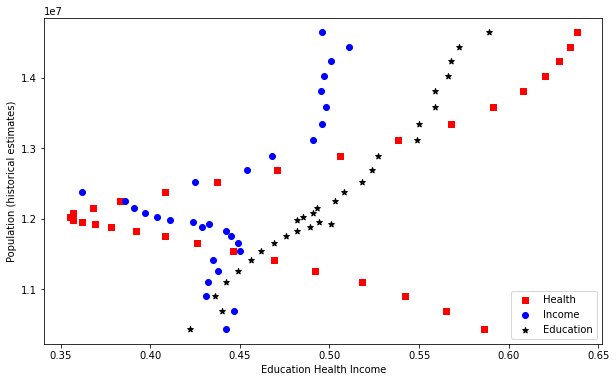

In [81]:
from sklearn import linear_model
%matplotlib inline  
from sklearn.preprocessing import minmax_scale
plt.rcParams['figure.figsize'] = (10, 6)
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
final=pd.read_csv('FINAL.csv')
#final.drop(columns='Unnamed: 0',inplace=True)
################################################################## לא חייב לייבא שוב את הקובץ פשוט לא רציתי להריץ את הקודמים 
final.describe()
plt.scatter(x=final.iloc[4980:]['Health'],y=final.iloc[4980:]['Population (historical estimates)'],c='r',marker='s',label='Health')
plt.scatter(x=final.iloc[4980:]['Income'],y=final.iloc[4980:]['Population (historical estimates)'],c='b',marker='o',label='Income')
plt.scatter(x=final.iloc[4980:]['Education'],y=final.iloc[4980:]['Population (historical estimates)'],c='k',marker='*',label='Education')

plt.legend(numpoints=1,loc=4)
plt.xlabel('Education Health Income')
plt.ylabel('Population (historical estimates)')
plt.show()

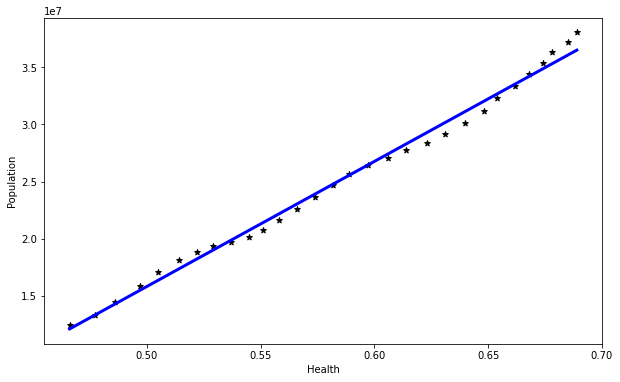

In [3]:
import numpy as np
import json
final=pd.read_csv('FINAL.csv')
final.drop(columns='Unnamed: 0',inplace=True)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
x=0
y=30
PopulationNormalized = pd.DataFrame(columns=['PopulationNormalized'])
newlist=[]
#בנינו פונקציה שמנרמלת את הנתונים בעמודה בנינו על כך שיש 30 שורות לכל מדינה ולכן חישבנו את הסכום בצורה כזו
for i in final.groupby('Entity')['Population (historical estimates)']:
    p=final.iloc[x:y]['Population (historical estimates)']/i[1].sum()
    newlist.append(p.to_list())

    x+=30
    y+=30

i=0
it=0
while True:
    if i==30:
        i=0
        it=it+1
    if it==len(newlist):
        break
    PopulationNormalized=PopulationNormalized.append({'PopulationNormalized':newlist[it][i]},ignore_index=True)
    
    i=i+1
    
    
PopulationNormalized.head()       

PopulationNormalized.to_csv('Population Normalized.csv')


38432377.39493513
39288135.808303595
40143894.22167206
40999652.63504052
41855411.048408985
42711169.46177745
43566927.87514591
44422686.288514376
45278444.70188308
46134203.11525154
46989961.528620005
47845719.94198847
48701478.35535693
49557236.768725395
50412995.18209386
51268753.59546232
52124512.008831024
52980270.42219949
53836028.83556795
54691787.248936415
55547545.66230488
56403304.07567334
57259062.489041805
58114820.90241027
58970579.31577897
59826337.729147434
60682096.1425159
61537854.55588436
62393612.969252825
63249371.38262129
64105129.79598975
64960888.209358215
65816646.62272668
66672405.03609538
67528163.44946384
68383921.86283231
69239680.27620077
70095438.68956923
70951197.1029377
71806955.51630616


0.9896063328878418

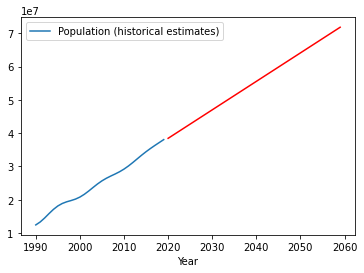

In [193]:
final=pd.read_csv('final1.csv')
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
x=0
y=30

final.iloc[x:y].plot(kind='line',x='Year',y='Population (historical estimates)')
X=final.iloc[0:30][['Year']]
y=final[0:30][['Population (historical estimates)']]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
reg=LinearRegression().fit(X_train,y_train)


pre = [] ; x_years = [2020,2060] # From each year to each year i want to check 
for i in range(x_years[0],x_years[1]):print(reg.predict([[i]])[0][0]),pre.append(reg.predict([[i]])[0][0])
plt.plot( np.arange(x_years[0],x_years[1],1), pre, color="red")
reg.score(X_test,y_test)

#plt.plot(X_test,predict,color="red")




# clf=LinearRegression()
# clf.fit(X_train,y_train)
# clf.predict(X_test)
# clf.score(X_test,y_test)


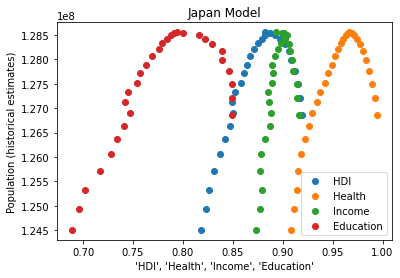

Prediction's precise : 76.75051262607289


In [89]:
final=pd.read_csv('final1.csv')
def scatterPrediction(x,y,l,label,country):
 
    for i in range(len(l)):
        plt.scatter(x[l[i]],y,label=l[i])
 
    plt.title(country + " Model")
    plt.xlabel(str(l).strip('[]'))#l
    plt.ylabel(label)#col_y
    plt.legend(numpoints=1,loc=4)
    plt.show()
 
 
 
  
def predict(dataset,country,col_x,col_y,testSize):
        rows = dataset.loc[dataset['Entity'] == country]
        con=1
        for i in col_x:
            #print(i)
            if(con==1):
                X=pd.DataFrame(rows[i],columns=[i])
                con=0
            X[i]=dataset[i]
        Y=rows[col_y]
        scatterPrediction(X,Y,col_x,col_y,country)
        Xtrain,Xtest,Ytrain,Ytest=train_test_split(X,Y,test_size=testSize)
        clf=LinearRegression()
        clf.fit(Xtrain,Ytrain)
        clf.predict(Xtest)
        print("Prediction's precise :",clf.score(Xtest,Ytest)*100)
k=list()
k.append('HDI')
k.append('Health')
k.append('Income')
k.append('Education')
predict(final,'Japan',k,'Population (historical estimates)',0.2)

In [53]:
final=pd.read_csv('FINAL.csv')
co2=pd.read_csv('annual-co2-emissions-per-country.csv')
co2 = co2[(co2['Year'] >= 1990) & (co2['Year'] <= 2019)]
newoutput = pd.merge(final, co2, how='left', on=['Entity', 'Year'])
newoutput.to_csv('final1.csv')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5010 entries, 0 to 5009
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         5010 non-null   int64  
 1   Entity                             5010 non-null   object 
 2   Year                               5010 non-null   int64  
 3   agricultural_land                  5010 non-null   float64
 4   PopulationNormalized               5010 non-null   float64
 5   Population (historical estimates)  5010 non-null   int64  
 6   Share of global forest area        5010 non-null   float64
 7   Birth by thousands                 5010 non-null   int64  
 8   Death by thousands                 5010 non-null   int64  
 9   undernourishment_prevalence        5010 non-null   float64
 10  Forest area                        5010 non-null   float64
 11  Health                             5010 non-null   float

In [55]:

final=pd.read_csv('final1.csv')
final.info()
final['Annual CO2 emissions'].fillna(final.groupby('Entity')['Annual CO2 emissions'].transform("mean"),inplace=True)
final['Calories per day'] = final['Calories per day'].fillna(0)
final.to_csv('final1.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5010 entries, 0 to 5009
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         5010 non-null   int64  
 1   Entity                             5010 non-null   object 
 2   Year                               5010 non-null   int64  
 3   agricultural_land                  5010 non-null   float64
 4   PopulationNormalized               5010 non-null   float64
 5   Population (historical estimates)  5010 non-null   int64  
 6   Share of global forest area        5010 non-null   float64
 7   Birth by thousands                 5010 non-null   int64  
 8   Death by thousands                 5010 non-null   int64  
 9   undernourishment_prevalence        5010 non-null   float64
 10  Forest area                        5010 non-null   float64
 11  Health                             5010 non-null   float

In [208]:
final=pd.read_csv('final1.csv')
import numpy as np
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
random_forest_model=RandomForestClassifier()

final['Hunger']=0
conditions = [(final['undernourishment_prevalence']<= 15),(final['undernourishment_prevalence'] > 15)]
values = [False, True]
list1=[]
final['Hunger'] = np.select(conditions, values)
final['HDI'].fillna(final.groupby('Entity')['HDI'].transform("mean"),inplace=True)    
final['HDI'] = final['HDI'].fillna(0)
for i in range(1990,2020):
    list1.append(final[(final['Year'] == i)]) 
x=1990  
feature_columns=['Health','Education','Income','HDI','Calories per day','Population (historical estimates)']
predicted_class=['Hunger']
for i in list1:
    print(x)
    X=i[feature_columns].values
    y=i[predicted_class].values
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
    random_forest_model.fit(X_train,y_train.ravel())
    predict_train_data=random_forest_model.predict(X_test)
    print("accuracy = {0:.3f}".format(metrics.accuracy_score(y_test,predict_train_data)))
    x+=1





1990
accuracy = 0.794
1991
accuracy = 0.794
1992
accuracy = 0.824
1993
accuracy = 0.706
1994
accuracy = 0.765
1995
accuracy = 0.824
1996
accuracy = 0.824
1997
accuracy = 0.588
1998
accuracy = 0.882
1999
accuracy = 0.912
2000
accuracy = 0.824
2001
accuracy = 0.853
2002
accuracy = 0.941
2003
accuracy = 0.824
2004
accuracy = 0.853
2005
accuracy = 0.882
2006
accuracy = 0.912
2007
accuracy = 0.824
2008
accuracy = 0.824
2009
accuracy = 0.912
2010
accuracy = 0.853
2011
accuracy = 0.853
2012
accuracy = 0.971
2013
accuracy = 0.824
2014
accuracy = 0.824
2015
accuracy = 0.882
2016
accuracy = 0.912
2017
accuracy = 0.824
2018
accuracy = 0.853
2019
accuracy = 0.794
